<a href="https://colab.research.google.com/github/Namit-Joshi/Doodle-io/blob/main/Doodleio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Tensorflow 2.2.0**
Need to downgrade for deployment purposes, as higher versions exceed slug size limit on Heroku. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# !pip uninstall tensorflow

In [3]:
# !pip install tensorflow==2.2.0

# **Importing Libraires**

In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading .npy files from Google Drive**

In [6]:
sheep = np.load('/content/drive/MyDrive/sheep.npy')
butterfly = np.load('/content/drive/MyDrive/butterfly.npy')
octopus = np.load('/content/drive/MyDrive/octopus.npy')
hedgehog = np.load('/content/drive/MyDrive/hedgehog.npy')
duck = np.load('/content/drive/MyDrive/duck.npy')
fish = np.load('/content/drive/MyDrive/fish.npy')

print(sheep.shape)
print(butterfly.shape)
print(octopus.shape)
print(hedgehog.shape)
print(duck.shape)
print(fish.shape)

(126121, 784)
(117999, 784)
(150152, 784)
(120527, 784)
(135480, 784)
(134150, 784)


For each class, we add a column to set the labels eg:- { 0:'sheep', 1:'butterfly', 2:'octopus', 3:'hedgehog', 4:'duck', 5:'fish'}

In [7]:
sheep = np.c_[sheep, np.zeros(len(sheep))]
butterfly = np.c_[butterfly, np.ones(len(butterfly))]
octopus = np.c_[octopus, 2*np.ones(len(octopus))]
hedgehog = np.c_[hedgehog, 3*np.ones(len(hedgehog))]
duck = np.c_[duck, 4*np.ones(len(duck))]
fish = np.c_[fish, 5*np.ones(len(fish))]
print(sheep.shape)

(126121, 785)


In [8]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

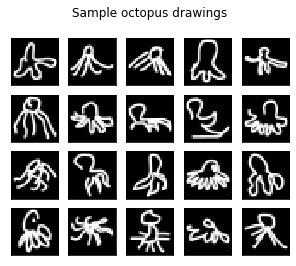

In [9]:
plot_samples(octopus, title='Sample octopus drawings\n')

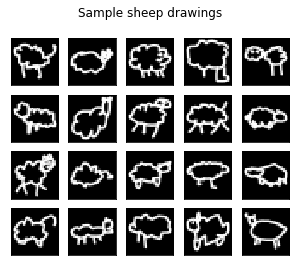

In [10]:
plot_samples(sheep, title='Sample sheep drawings\n')

# **Preprocessing**

In [11]:
# Merging arrays and splitting the features and labels
X = np.concatenate((sheep[:15000,:-1], butterfly[:15000,:-1], octopus[:15000,:-1], hedgehog[:15000,:-1], duck[:15000,:-1], fish[:15000, :-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((sheep[:15000,-1], butterfly[:15000,-1], octopus[:15000,-1], hedgehog[:15000,-1], duck[:15000,-1],  fish[:15000,-1]), axis=0).astype('float32') # the last column

# We than split data between train and test (80 - 20 usual ratio). Normalizing the value between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.2,random_state=0)

In [12]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [13]:
# reshape to be (batch, height, width, channels) - Tensorflow Format
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# **Defining the Model**

In [14]:
def cnn_model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))

  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64,(3, 3)))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))

  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  # Fully connected layer
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6))

  model.add(Activation('softmax'))
  # Compile Model
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
  return model

# **Data Augmentation**
To reduce over-fitting, we use another technique known as Data Augmentation. Data augmentation rotates, shears, zooms, etc the image so that the model learns to generalize and not remember specific data. If the model overfits, it will perform very well on the images that it already knows but will fail if new images are given to it.

In [15]:
%%time
np.random.seed(0)
# build the model
model_cnn = cnn_model()

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

CPU times: user 681 ms, sys: 44.8 ms, total: 726 ms
Wall time: 896 ms


In [16]:
train_generator = gen.flow(X_train_cnn, y_train_cnn, batch_size=64)
test_generator = test_gen.flow(X_test_cnn, y_test_cnn, batch_size=64)

# **Model Fitting**

In [17]:
# Fit the model
model_cnn.fit(train_generator, steps_per_epoch=72000//64, epochs=5, validation_data=test_generator, validation_steps=18000//64)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Epoch 1/5
1125/1125 [==============================] - 246s 219ms/step - loss: 0.3448 - accuracy: 0.8882 - val_loss: 0.2407 - val_accuracy: 0.9282
Epoch 2/5
1125/1125 [==============================] - 245s 218ms/step - loss: 0.2241 - accuracy: 0.9273 - val_loss: 0.2099 - val_accuracy: 0.9394
Epoch 3/5
1125/1125 [==============================] - 247s 220ms/step - loss: 0.1956 - accuracy: 0.9370 - val_loss: 0.2952 - val_accuracy: 0.9200
Epoch 4/5
1125/1125 [==============================] - 247s 220ms/step - loss: 0.1807 - accuracy: 0.9413 - val_loss: 0.2030 - val_accuracy: 0.9409
Epoch 5/5
1125/1125 [==============================] - 248s 220ms/step - loss: 0.1684 - accuracy: 0.9452 - val_loss: 0.1875 - val_accuracy: 0.9448
Final CNN accuracy:  0.9448888897895813


In [18]:
y_pred_cnn = model_cnn.predict_classes(X_test_cnn, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


# **Confusion Matrix**

In [19]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test, y_pred_cnn)

In [20]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

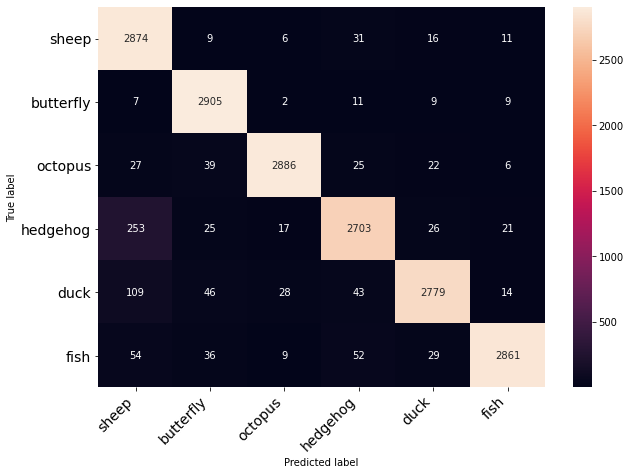

In [21]:
class_names = ['sheep', 'butterfly', 'octopus', 'hedgehog', 'duck', 'fish']
confusion_matrix(c_matrix, class_names, figsize = (10,7), fontsize=14)

In [22]:
#Misclassification when y_pred and y_test are different.
misclassified = X_test[y_pred_cnn != y_test]

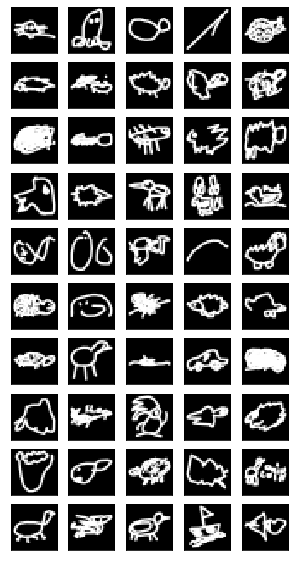

In [23]:
plot_samples(misclassified, rows=10, cols=5, title='')

# **Saving the Model**

In [24]:
from keras.models import load_model 
model_cnn.save("quickdraw.h5")